In [ ]:
import pytesseract
import cv2
from PIL import Image
import numpy as np
import re
import config
import clr
import os
clr.AddReference(os.path.abspath(config.FIT_DLL))
from Dynastream.Fit import * # type: ignore

pytesseract.pytesseract.tesseract_cmd = r'/usr/local/bin/tesseract'

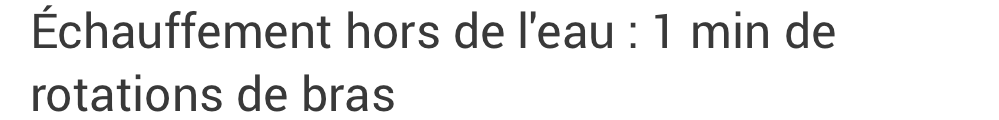

Echauffement hors de l'eau : 1 min de
rotations de bras



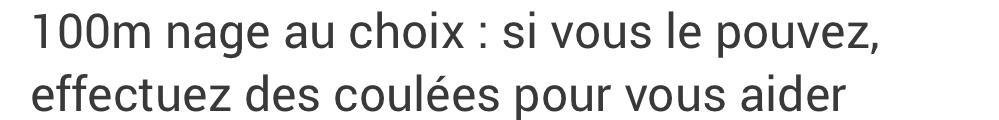

100m nage au choix : si vous le pouvez,
effectuez des coulées pour vous aider



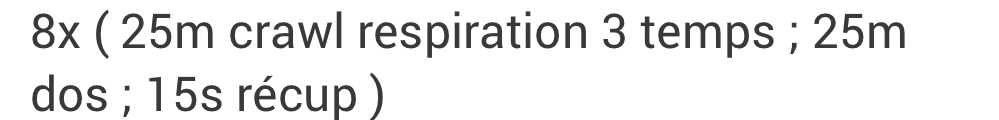

8x (25m crawl respiration 3 temps ; 25m
dos ; 15s récup )



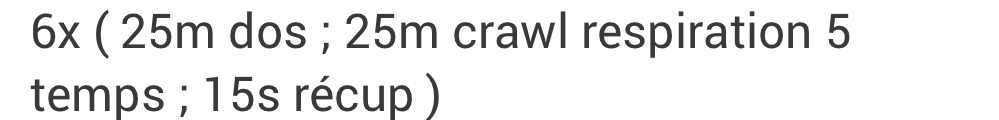

6x (25m dos ; 25m crawl respiration 5
temps ; 15s récup )



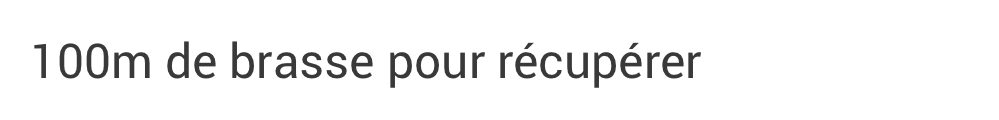

100m de brasse pour récupérer



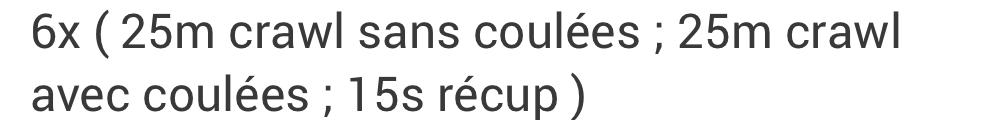

6x (25m crawl sans coulées ; 25m crawl
avec coulées ; 15s récup )



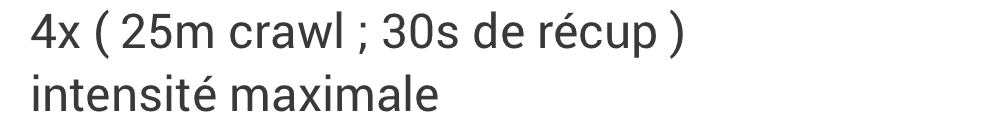

4x (25m crawl ; 30s de récup )
intensité maximale



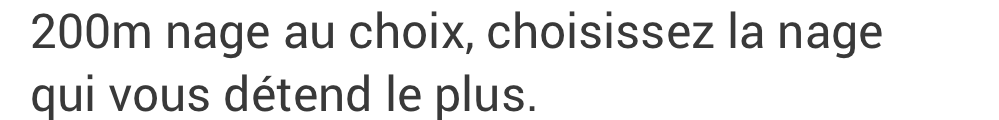

200m nage au choix, choisissez la nage
qui vous détend le plus.



In [ ]:
img = "IMG_9245"

img_path = f"images/{img}.PNG"

# display(Image.open(img_path))



image_bgr = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image_hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)

# Define blue range in HSV
lower_blue = np.array([90, 50, 50])
upper_blue = np.array([130, 255, 255])
mask = cv2.inRange(image_hsv, lower_blue, upper_blue)

instructions = []

contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours[::-1]:
    x, y, w, h = cv2.boundingRect(cnt)
    if w > 100 and w < 200 and h > 100:  # Filter out small noise
        # Crop a horizontal strip to the right of the blue circle
        line_crop = image_rgb[y:y+h, x+w:x+w+1000] # Adjust width as needed

        # Convert to PIL Image for pytesseract
        pil_img = Image.fromarray(line_crop)

        display(pil_img) # for debugging

        text = pytesseract.image_to_string(pil_img)

        print(text)

        instructions.append(text.replace('\n', '').replace(' ', '').strip())

In [ ]:
from Swimming import SwimmingWorkout, SwimmingWorkoutStepRepeat, SwimmingWorkoutStepSwim, SwimmingWorkoutStepSwimRest, SwimingWorkoutWarmup

workout_steps = []

message_index = 0
for instruction in instructions:

    pattern_warmup = re.search(r"Echauffementhorsdel'eau*:(\d+)min(.*)", instruction, re.IGNORECASE)
    if pattern_warmup:

        minutes = int(pattern_warmup.group(1))
        type = pattern_warmup.group(2)

        workout_steps.append(
            SwimingWorkoutWarmup.create_workout_step_swim_warmup(
                message_index= message_index, 
                name= "Out of pool warmup",
                duration_time= minutes
            )
        )

    pattern_choice = re.search(r"(\d+)mnageauchoix", instruction, re.IGNORECASE)
    if pattern_choice:

        distance = pattern_choice.group(1)

        workout_steps.append(
            SwimmingWorkoutStepSwim.create_workout_step_swim(
                message_index= message_index,
                distance= int(distance),
                swim_stroke= SwimStroke.Freestyle # type: ignore
            )
        )

    pattern_repeat = re.search(r'(\d+)\s*[x×]\s*\((.*?)\)', instruction, re.IGNORECASE)
    if pattern_repeat:
        
        start_repeat = message_index
        
        times = int(pattern_repeat.group(1))
        tasks = str(pattern_repeat.group(2).strip()).split(';')

        for task in tasks:
            
            pattern_distance = re.search(r'(\d+)\s*m\s*(.*)', task, re.IGNORECASE)
            if pattern_distance:
                distance = int(pattern_distance.group(1))
                swim_type = pattern_distance.group(2).strip().lower()
                workout_steps.append(
                    SwimmingWorkoutStepSwim.create_workout_step_swim(
                        message_index= message_index,
                        distance= distance,
                        swim_stroke= SwimStroke.Invalid # type: ignore
                    )
                )
                message_index += 1
            pattern_rest = re.search(r'(\d+)\s*s\s*récup', task, re.IGNORECASE)
            # pattern_rest = re.search(r'(\d+)\s*s\s*', task, re.IGNORECASE)
            
            if pattern_rest:
                rest_time = float(pattern_rest.group(1))

                workout_steps.append(
                    SwimmingWorkoutStepSwimRest.create_workout_step_swim_rest(
                        message_index= message_index,
                        duration_time= rest_time
                    )
                )
                message_index += 1

        workout_steps.append(
            SwimmingWorkoutStepRepeat.create_workout_step_repeat(
                message_index= message_index,
                repeat_from= start_repeat,  # Adjust based on how many steps were added
                repetitions= times
            )
        )

activity_name = f"activity_from_{img}"

workout_mesg = WorkoutMesg() # type: ignore
workout_mesg.SetWktName(activity_name)
workout_mesg.SetSport(Sport.Swimming) # type: ignore
workout_mesg.SetSubSport(SubSport.LapSwimming) # type: ignore
workout_mesg.SetPoolLengthUnit(DisplayMeasure.Metric) # type: ignore
workout_mesg.SetPoolLength(50)
workout_mesg.SetNumValidSteps(len(workout_steps))

SwimmingWorkout.create_workout(workout_mesg, workout_steps)

os.makedirs('./jsons', exist_ok=True)

from garmin_fit_sdk import Decoder, Stream
import json

stream = Stream.from_file(f"./fits/{activity_name}.fit")
decoder = Decoder(stream)
messages, errors = decoder.read()

with open(f"./jsons/{activity_name}.json", 'w') as f:
    json.dump(messages, f, default= str)
    print(f"Decoded messages to {activity_name}.json")

Echauffementhorsdel'eau:1minderotationsdebras
100mnageauchoix:sivouslepouvez,effectuezdescouléespourvousaider
8x(25mcrawlrespiration3temps;25mdos;15srécup)
6x(25mdos;25mcrawlrespiration5temps;15srécup)
100mdebrassepourrécupérer
6x(25mcrawlsanscoulées;25mcrawlaveccoulées;15srécup)
4x(25mcrawl;30sderécup)intensitémaximale
200mnageauchoix,choisissezlanagequivousdétendleplus.
Encoded FIT file /Users/hippolyteleprelle/Projects/garmin/fits/activity_from_IMG_9245.fit
Decoded messages to activity_from_IMG_9245.json
